In [289]:
import pywt
import numpy as np
from PIL import Image

class DWT:
    def __init__(self, img_path):
        self.img_path = img_path
        self.img_array = np.array(Image.open(img_path))

    def embed_watermark(self, watermark, key, alpha):
        # Perform 3-level DWT on the image
        coeffs = pywt.wavedec(self.img_array, 'haar', level=3)
        print('DWT coefficients:', coeffs)
        # Embed the watermark into the LL3 subband of DWT coefficients using QIM
        LL3 = coeffs[0]
        LL3_shape = LL3.shape
        watermark_length = watermark.shape[0]

        step_size = 2 * alpha / 2**16  # quantization step size
        threshold = alpha  # threshold for deciding the watermark bit

        np.random.seed(key)
        watermark_indices = np.random.choice(np.arange(LL3_shape[0]*LL3_shape[1]), watermark_length, replace=False)
        print('Watermark indices:', watermark_indices)
        for i, index in enumerate(watermark_indices):
            bit = watermark[i]
            row = index // LL3_shape[1]
            col = index % LL3_shape[1]

            # Embed the watermark bit into the LL3 coefficient using QIM
            q = LL3[row, col] // step_size
            print('LL3 coefficient:', LL3[row, col])
            print('Quantization step size:', step_size)
            print('Threshold:', threshold)
            print('Watermark bit:', bit)
            if (bit == 0 and q % 2 == 1) or (bit == 1 and q % 2 == 0):
                # Flip the LSB of the LL3 coefficient if the watermark bit is different from q
                if LL3[row, col] > threshold:
                    LL3[row, col] -= step_size / 2
                else:
                    LL3[row, col] += step_size / 2

        # Reconstruct the image from the modified DWT coefficients
        watermarked_coeffs = [LL3] + coeffs[1:]
        print('Watermarked coeffs:', watermarked_coeffs)
        watermarked_array = pywt.waverec(watermarked_coeffs, 'haar')
        print('Watermarked image:', watermarked_array)

        # Save the watermarked image
        watermarked_img = Image.fromarray(watermarked_array.astype(np.uint8))
        watermarked_img.save('watermarked_image3.bmp')

    def extract_watermark(self, watermark_length, watermark_key, alpha):
        # Perform 3-level DWT on the watermarked image
        watermarked_array = np.array(Image.open('watermarked_image3.bmp'))
        watermarked_coeffs = pywt.wavedec(watermarked_array, 'haar', level=3)
        print('Watermarked DWT coefficients:', watermarked_coeffs)
        # Extract the watermark from the watermarked image using the same key and scrambling
        LL3_wm = watermarked_coeffs[0]
        LL3_shape = LL3_wm.shape

        # Count the number of scrambled pixels used to embed the watermark
        np.random.seed(watermark_key)
        scrambled_pixels = np.random.permutation(np.arange(LL3_shape[0] * LL3_shape[1]))[:watermark_length]
        print("this is scramble",scrambled_pixels)
        extracted_watermark = np.zeros(watermark_length, dtype=np.uint8)

        step_size = 2 * alpha / 2**16  # quantization step size
        threshold = alpha  # threshold for deciding the watermark bit

        scramble = np.zeros(LL3_shape, dtype=np.uint8)
        np.random.seed(watermark_key)
        scramble[np.random.permutation(np.arange(LL3_shape[0])), np.random.permutation(np.arange(LL3_shape[1]))] = 1

        for i, pixel_idx in enumerate(scrambled_pixels):
            row = pixel_idx // LL3_shape[1]
            print("row",row)
            col = pixel_idx % LL3_shape[1]
            print("col",col)
            if scramble[row, col] != 1:
                q = LL3_wm[row, col] // step_size
                print('LL3 coefficient 1:', LL3_wm[row, col])
                print('Quantization step size1:', step_size)
                print('Threshold1:', threshold)
                if q % 2 == 0:
                    extracted_watermark[i] = 0
                else:
                    extracted_watermark[i] = 1
                print('Extracted bit:', extracted_watermark[i])
        return extracted_watermark
    def extract_watermark_noise(self, watermark_length, watermark_key, alpha):
        # Perform 3-level DWT on the watermarked image
        watermarked_array = np.array(Image.open('noisy_image3.bmp'))
        watermarked_coeffs = pywt.wavedec(watermarked_array, 'haar', level=3)
        print('Watermarked DWT coefficients:', watermarked_coeffs)
        # Extract the watermark from the watermarked image using the same key and scrambling
        LL3_wm = watermarked_coeffs[0]
        LL3_shape = LL3_wm.shape

        # Count the number of scrambled pixels used to embed the watermark
        np.random.seed(watermark_key)
        scrambled_pixels = np.random.permutation(np.arange(LL3_shape[0] * LL3_shape[1]))[:watermark_length]
        print("this is scramble",scrambled_pixels)
        extracted_watermark = np.zeros(watermark_length, dtype=np.uint8)

        step_size = 2 * alpha / 2**16  # quantization step size
        threshold = alpha  # threshold for deciding the watermark bit

        scramble = np.zeros(LL3_shape, dtype=np.uint8)
        np.random.seed(watermark_key)
        scramble[np.random.permutation(np.arange(LL3_shape[0])), np.random.permutation(np.arange(LL3_shape[1]))] = 1

        for i, pixel_idx in enumerate(scrambled_pixels):
            row = pixel_idx // LL3_shape[1]
            print("row",row)
            col = pixel_idx % LL3_shape[1]
            print("col",col)
            if scramble[row, col] != 1:
                q = LL3_wm[row, col] // step_size
                print('LL3 coefficient 1:', LL3_wm[row, col])
                print('Quantization step size1:', step_size)
                print('Threshold1:', threshold)
                if q % 2 == 0:
                    extracted_watermark[i] = 0
                else:
                    extracted_watermark[i] = 1
                print('Extracted bit:', extracted_watermark[i])
        return extracted_watermark


In [290]:
watermark_text = 'Haya And Maria'
watermark_bytes = watermark_text.encode('utf-8')
watermark_bin = ''.join(format(byte, '08b') for byte in watermark_bytes)
watermark=np.array([int(bit) for bit in watermark_bin])
# Call the embed_watermark function with the binary watermark
dwt = DWT('PeppersRGB.bmp')
key = 12345
alpha = 1
dwt.embed_watermark(watermark, key, alpha)
extracted_watermark = dwt.extract_watermark(len(watermark), key, alpha)

# Print the extracted watermark
print("Extracted watermark:", extracted_watermark)
print("Watermark",watermark)

DWT coefficients: [array([[[ 71.4177849 ],
        [299.81327522],
        [313.24830407],
        ...,
        [359.21024484],
        [395.27269068],
        [340.82546853]],

       [[ 86.97413409],
        [267.99347007],
        [267.99347007],
        ...,
        [371.9381669 ],
        [350.72496347],
        [337.28993463]],

       [[ 89.09545443],
        [273.65032432],
        [264.45793616],
        ...,
        [371.9381669 ],
        [354.96760416],
        [340.82546853]],

       ...,

       [[ 65.05382387],
        [253.14422766],
        [275.06453788],
        ...,
        [524.67323164],
        [514.06662992],
        [455.37676708]],

       [[ 65.05382387],
        [261.62950904],
        [238.29498526],
        ...,
        [503.4600282 ],
        [510.53109602],
        [420.72853481]],

       [[ 65.76093065],
        [190.91883092],
        [275.77164466],
        ...,
        [470.22600949],
        [521.84480452],
        [523.25901808]]]), array([[[0.],

In [291]:
extracted_watermark2 = dwt.extract_watermark_noise(len(watermark), key, alpha)

Watermarked DWT coefficients: [array([[[ 71.4177849 ],
        [307.59144982],
        [313.95541085],
        ...,
        [357.79603128],
        [406.58639918],
        [345.06810922]],

       [[ 88.38834765],
        [265.87214973],
        [267.28636329],
        ...,
        [371.9381669 ],
        [356.38181772],
        [335.16861428]],

       [[ 88.38834765],
        [275.06453788],
        [265.16504294],
        ...,
        [370.52395334],
        [355.67471094],
        [336.58282784]],

       ...,

       [[ 64.34671709],
        [253.14422766],
        [277.89296501],
        ...,
        [526.0874452 ],
        [504.87424177],
        [452.54833996]],

       [[ 65.05382387],
        [260.92240226],
        [241.12341238],
        ...,
        [505.58134855],
        [506.28845533],
        [424.26406871]],

       [[ 65.76093065],
        [191.6259377 ],
        [275.06453788],
        ...,
        [470.93311627],
        [521.84480452],
        [533.8656198 ]]]), a

PSNR

In [292]:
import numpy as np
from PIL import Image

def calculate_psnr(img1_path, img2_path):
    # Open images and convert to numpy arrays
    img1 = np.array(Image.open(img1_path))
    img2 = np.array(Image.open(img2_path))
    
    # Ensure the images are the same size
    if img1.shape != img2.shape:
        raise ValueError('Images must be the same size')
    
    # Calculate the mean squared error
    mse = np.mean((img1 - img2)**2)
    
    # Calculate the maximum possible pixel value
    max_pixel = 255.0
    
    # Calculate the PSNR
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    
    return psnr


In [294]:
psnr = calculate_psnr('noisy_image3.bmp', 'PeppersRGB.bmp')
print('PSNR:', psnr)


PSNR: 39.85073695933372


In [295]:
psnr = calculate_psnr('watermarked_image3.bmp', 'PeppersRGB.bmp')
print('PSNR:', psnr)


PSNR: 68.93495945622672


NC

In [260]:
import numpy as np

def normalized_cross_correlation_bits(watermark_original, watermark_extracted):
    dot_product = np.dot(watermark_original, watermark_extracted)
    norm_a = np.linalg.norm(watermark_original)
    norm_b = np.linalg.norm(watermark_extracted)
    return dot_product / (norm_a * norm_b)


In [296]:


original_watermark = np.array(watermark)
extracted_watermark = np.array(extracted_watermark)
ncc = normalized_cross_correlation_bits(original_watermark, extracted_watermark)
print("Normalized Cross-Correlation: ", ncc)


Normalized Cross-Correlation:  0.4441026811597043


MSE

In [297]:
def calculate_mse(original, extracted):
    """Calculates the mean squared error (MSE) between two arrays of bits"""
    if len(original) != len(extracted):
        raise ValueError("The length of the original and extracted arrays must be equal")
    mse = np.mean((original - extracted) ** 2)
    return mse


In [298]:
# Assuming original and extracted are numpy arrays or lists of bits
mse = calculate_mse(watermark, extracted_watermark)
print("MSE:", mse)


MSE: 0.4732142857142857


In [299]:
# Assuming original and extracted are numpy arrays or lists of bits
mse = calculate_mse(watermark, extracted_watermark2)
print("MSE:", mse)


MSE: 0.5982142857142857


Noise

In [316]:
import cv2
import numpy as np

def add_speckle_noise(image_path, stddev, output_path):
    # Load the image
    img = cv2.imread(image_path)

    # Add speckle noise
    noise = np.random.normal(0, stddev, img.shape)
    noisy_img = img + img * noise

    # Save the noisy image
    cv2.imwrite(output_path, noisy_img)

    return noisy_img

In [287]:
noisy_img = add_speckle_noise('watermarked_image3.bmp', 0.02, 'noisy_image3.bmp')


In [288]:
cv2.imshow('Noisy Image', noisy_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

SSIM

In [315]:
from skimage import img_as_float
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(image1, image2):
    # Convert images to floating point representation
    image1 = img_as_float(image1)
    image2 = img_as_float(image2)

    # Calculate SSIM between the two images
    ssim_val, _ = ssim(image1, image2, multichannel=True, full=True)

    return ssim_val


In [302]:
from skimage import io

# Load two color images
image1 = io.imread("noisy_image3.bmp")
image2 = io.imread("PeppersRGB.bmp")

# Calculate SSIM between the two images
ssim_val = calculate_ssim(image1, image2)

print("The SSIM between the two images is:", ssim_val)


SSIM score: 0.06850042643917344


In [303]:
import numpy as np
from PIL import Image
from skimage.metrics import structural_similarity as ssim

def bits_to_image(bits, font_size):
    # Convert the bits array to a grayscale image
    num_chars = len(bits)
    num_cols = int(np.ceil(num_chars / font_size))
    num_rows = font_size
    image_array = np.zeros((num_rows, num_cols), dtype=np.uint8)
    for i in range(num_chars):
        row = i % num_rows
        col = i // num_rows
        image_array[row, col] = bits[i] * 255
    
    # Resize the image to a standard size
    target_size = (font_size * 10, font_size)
    image = Image.fromarray(image_array)
    image = image.resize(target_size, resample=Image.NEAREST)
    
    # Convert the PIL Image to a NumPy array
    image_array = np.array(image)
    
    return image_array

def calculate_ssim(original_watermark, extracted_watermark, font_size):
    # Convert bit arrays to grayscale images
    original_image = bits_to_image(original_watermark, font_size)
    extracted_image = bits_to_image(extracted_watermark, font_size)

    # Calculate SSIM
    ssim_score = ssim(original_image, extracted_image, data_range=255)

    return ssim_score


In [304]:

# Calculate SSIM
ssim_score = calculate_ssim(watermark, extracted_watermark2,10)

print('SSIM score:', ssim_score)


SSIM score: -0.04762693393983755


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5988\1699517784.py:19: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image = image.resize(target_size, resample=Image.NEAREST)


noisy img

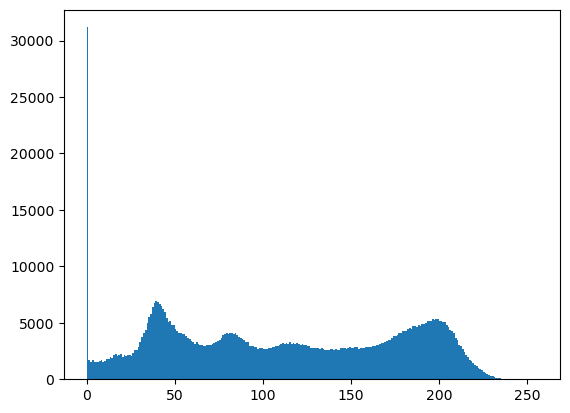

In [305]:
import matplotlib.pyplot as plt

hist, bins = np.histogram(noisy_img.ravel(), 256, [0,256])
plt.hist(noisy_img.ravel(), 256, [0,256])
plt.show()

watermarked image

In [306]:
img2 = cv2.imread('watermarked_image3.bmp')

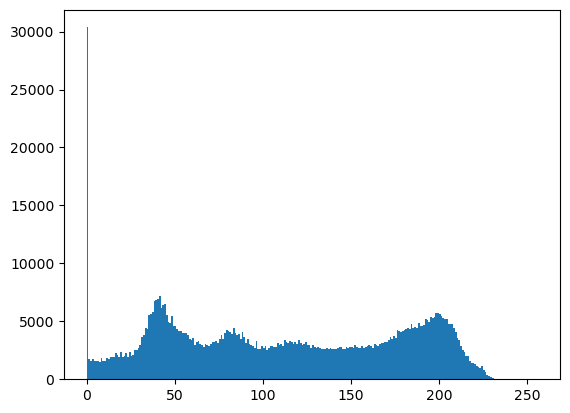

In [307]:
import matplotlib.pyplot as plt

hist, bins = np.histogram(img2.ravel(), 256, [0,256])
plt.hist(img2.ravel(), 256, [0,256])
plt.show()

original_image

In [308]:
img1 = cv2.imread('PeppersRGB.bmp')

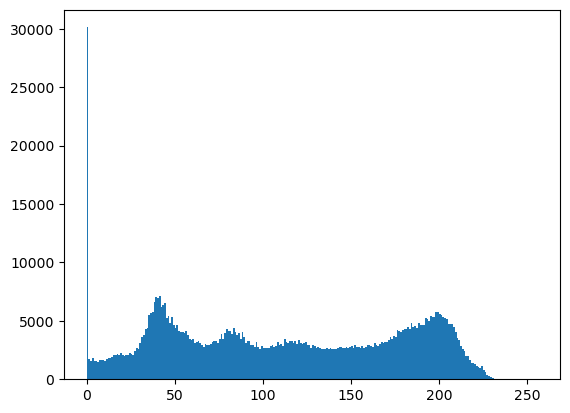

In [309]:

hist, bins = np.histogram(img1.ravel(), 256, [0,256])
plt.hist(img1.ravel(), 256, [0,256])
plt.show()